In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.autograd.profiler as profiler


# Define transformations for the training and test datasets, including data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset with increased batch size and data augmentation
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the network, loss function, and optimizer with GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_decay = 1e-4  # Regularization strength
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=weight_decay)

# Define class names for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Lists to store training and testing metrics
train_times = []
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 50

# Training and testing loops
for epoch in range(num_epochs):
    # Training
    net.train()  # Set the model to training mode
    start_time = time.time()  # Record the start time of the epoch
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    end_time = time.time()
    epoch_time = end_time - start_time
    train_times.append(epoch_time)

    avg_loss = running_loss / len(trainloader)
    accuracy = correct_predictions / total_samples
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)


    # Testing
    net.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    sample_images = []
    true_labels = []
    predicted_labels = []
    misclassified_images = []
    misclassified_true_labels = []
    misclassified_predicted_labels = []

    with torch.no_grad():
        all_true_labels = []
        all_predicted_labels = []
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            misclassified_indices = (predicted != labels).nonzero()[:, 0]

            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

            # Store sample images, true labels, and predicted labels for a few examples
            for j in range(len(labels)):
                if len(sample_images) < 20:  # Store only 5 sample images
                    sample_images.append(inputs[j].cpu())
                    true_labels.append(class_names[labels[j].cpu().item()])  # Get class name instead of label number
                    predicted_labels.append(class_names[predicted[j].cpu().item()])  # Get class name instead of label number

            for idx in misclassified_indices:
                misclassified_images.append(inputs[idx].cpu())
                misclassified_true_labels.append(class_names[labels[idx].cpu().item()])
                misclassified_predicted_labels.append(class_names[predicted[idx].cpu().item()])


    avg_test_loss = test_loss / len(testloader)
    test_accuracy = correct_predictions / total_samples
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    # Print training statistics including average time for the current epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy * 100:.2f}%, '
          f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')


# Calculate the total training time
total_training_time = sum(train_times)

# Calculate the average time spent on each epoch
average_time_per_epoch = total_training_time / num_epochs

print(f'Total training time: {total_training_time:.2f} seconds')
print(f'Average time spent on each epoch: {average_time_per_epoch:.2f} seconds')

# Compute confusion matrix, accuracy, precision, and recall
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
f1_score = f1_score(all_true_labels, all_predicted_labels, average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1_score:.2f}')

Epoch [1/50], Training Loss: 1.4339, Training Accuracy: 47.65%, Test Loss: 1.1387, Test Accuracy: 58.97%
Epoch [2/50], Training Loss: 0.9981, Training Accuracy: 64.58%, Test Loss: 0.8956, Test Accuracy: 68.63%
Epoch [3/50], Training Loss: 0.8226, Training Accuracy: 70.92%, Test Loss: 0.8131, Test Accuracy: 71.55%
Epoch [4/50], Training Loss: 0.7250, Training Accuracy: 74.58%, Test Loss: 0.7022, Test Accuracy: 75.77%
Epoch [5/50], Training Loss: 0.6462, Training Accuracy: 77.13%, Test Loss: 0.6932, Test Accuracy: 76.00%
Epoch [6/50], Training Loss: 0.5888, Training Accuracy: 79.31%, Test Loss: 0.6435, Test Accuracy: 77.59%
Epoch [7/50], Training Loss: 0.5387, Training Accuracy: 81.26%, Test Loss: 0.6431, Test Accuracy: 77.85%
Epoch [8/50], Training Loss: 0.4929, Training Accuracy: 82.75%, Test Loss: 0.6834, Test Accuracy: 77.05%
Epoch [9/50], Training Loss: 0.4547, Training Accuracy: 83.93%, Test Loss: 0.5973, Test Accuracy: 79.78%
Epoch [10/50], Training Loss: 0.4156, Training Accuracy

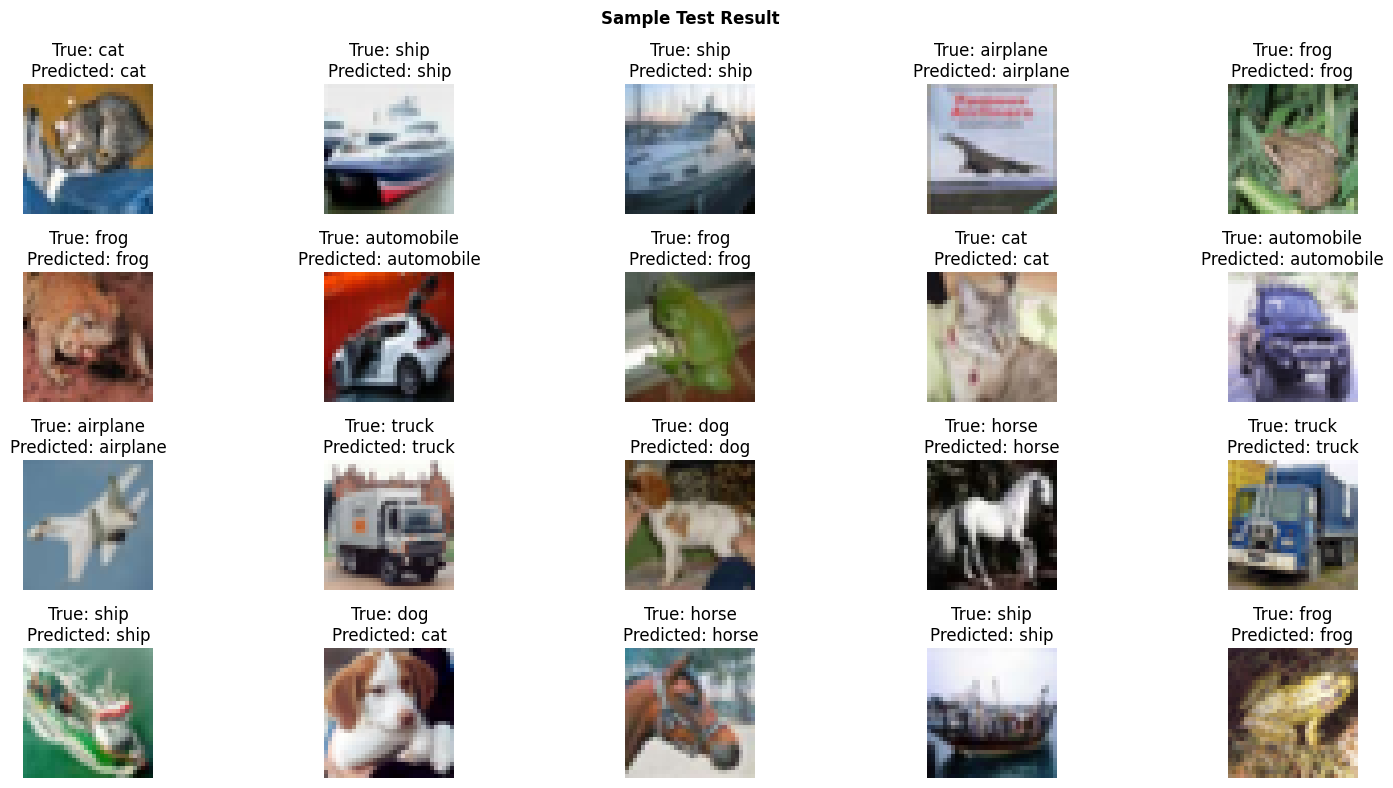

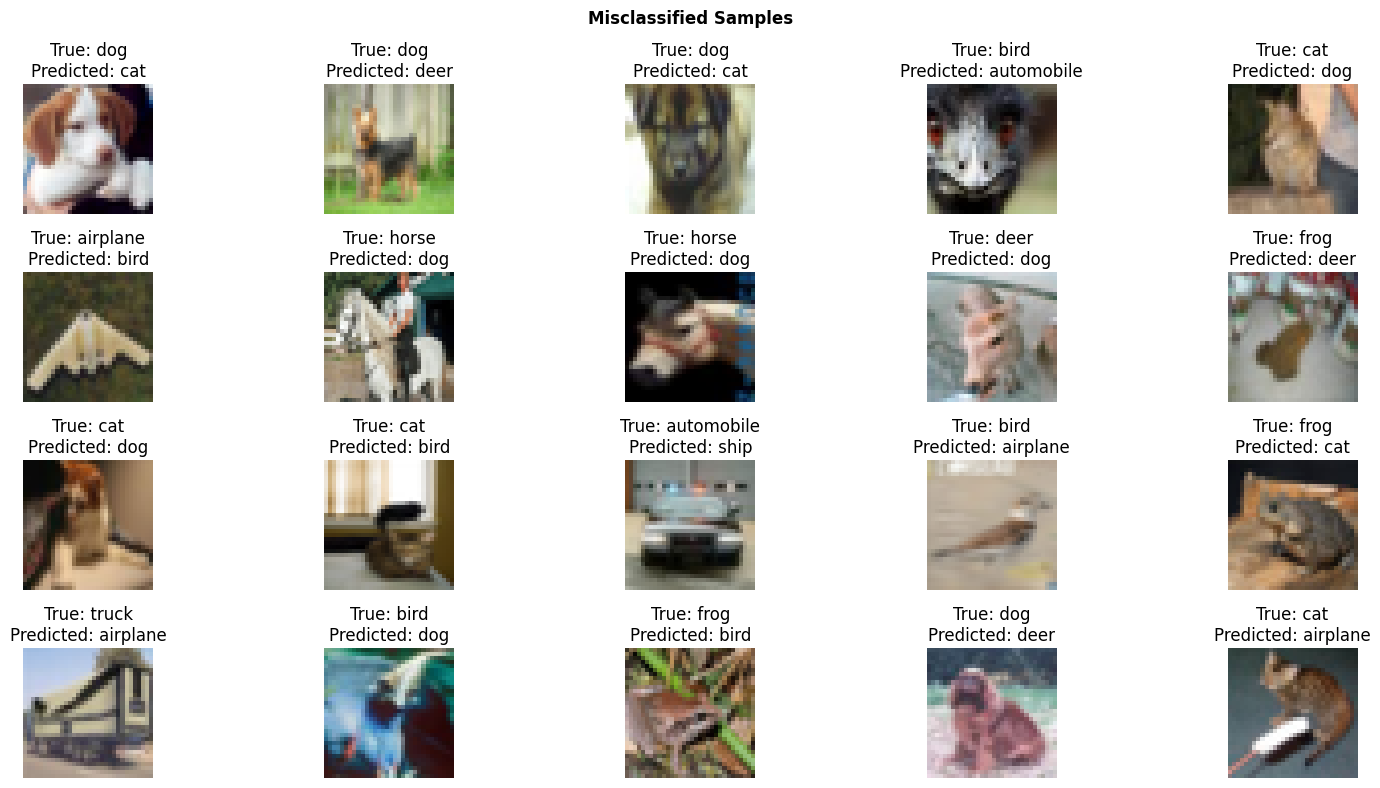

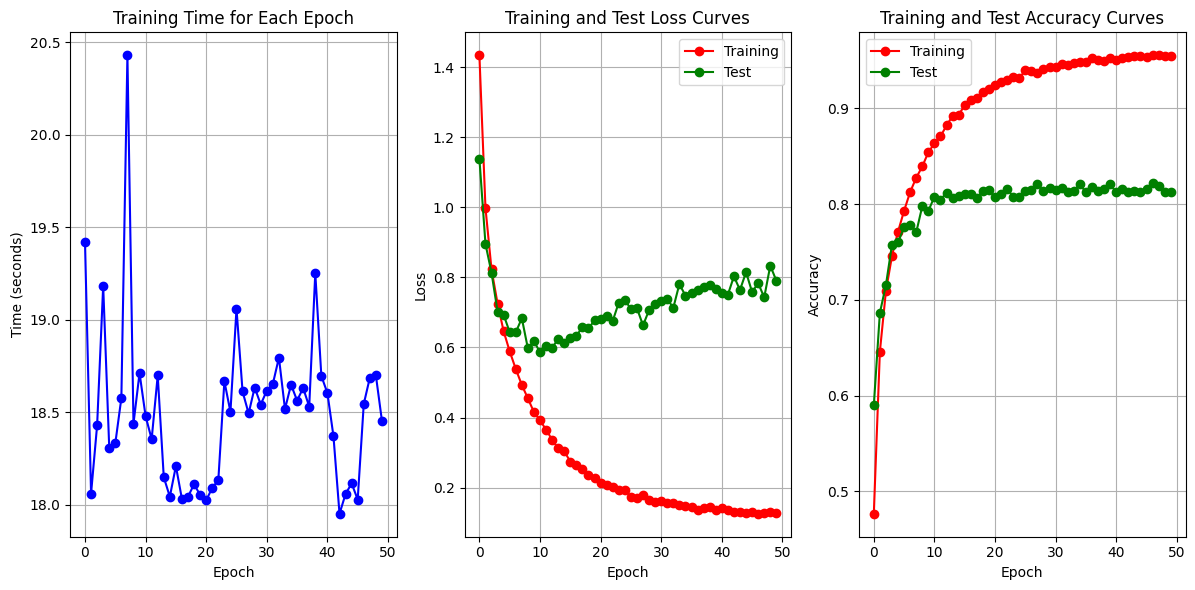

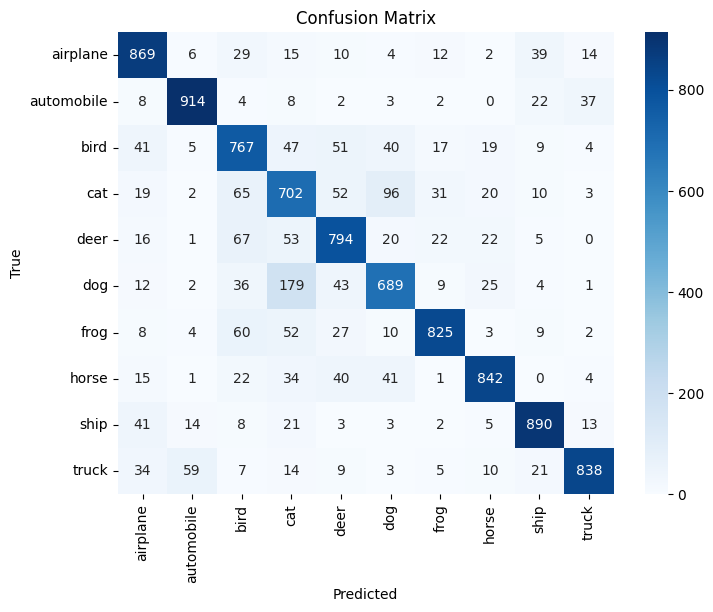

In [3]:
from prettytable import PrettyTable

# Display sample images along with true and predicted labels
plt.figure(figsize=(16, 8))
plt.suptitle('Sample Test Result', weight="bold")
for i in range(len(sample_images)):
    plt.subplot(4, 5, i + 1)
    image = sample_images[i].permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize the image
    plt.imshow(image.numpy())
    plt.title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Display some correctly classified images along with true and predicted labels
plt.figure(figsize=(16, 8))
plt.suptitle('Misclassified Samples', weight="bold")
for i in range(20):
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns for 20 images
    image = misclassified_images[i].permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize the image
    plt.imshow(image.numpy())
    plt.title(f'True: {misclassified_true_labels[i]}\nPredicted: {misclassified_predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Plotting training and testing metrics
plt.figure(figsize=(16, 6))

# Plot training time
plt.subplot(1, 4, 1)
plt.plot(train_times, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Training Time for Each Epoch')
plt.grid(True)

# Plot training and testing loss curves
plt.subplot(1, 4, 2)
plt.plot(train_losses, marker='o', linestyle='-', color='r', label='Training')
plt.plot(test_losses, marker='o', linestyle='-', color='g', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.grid(True)

# Plot training and testing accuracy curves
plt.subplot(1, 4, 3)
plt.plot(train_accuracies, marker='o', linestyle='-', color='r', label='Training')
plt.plot(test_accuracies, marker='o', linestyle='-', color='g', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Visualize confusion matrix
plt.figure(figsize=(8, 6))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [4]:
from prettytable import PrettyTable

# Create a colored table for accuracy, precision, and recall
table = PrettyTable(['Metric', 'Value'])
table.title = 'Model Metrics'
table.align['Metric'] = 'l'
table.align['Value'] = 'r'
table.add_row(['\033[92mAccuracy\033[0m', f'{accuracy * 100:.2f}%'])
table.add_row(['\033[91mPrecision\033[0m', f'{precision:.2f}'])
table.add_row(['\033[94mRecall\033[0m', f'{recall:.2f}'])

# Print the colored table
print(table)

+--------------------+
|   Model Metrics    |
+-----------+--------+
| Metric    |  Value |
+-----------+--------+
| Accuracy  | 81.30% |
| Precision |   0.82 |
| Recall    |   0.81 |
+-----------+--------+
